## Scipy Sparse Matrix

There are several sparse formats that can be useful for various problems:

- `CSR` (compressed sparse row)
- `CSC` (compressed sparse column)
- `BSR` (block sparse row)
- `COO` (coordinate)
- `DIA` (diagonal)
- `DOK` (dictionary of keys)

The ``scipy.sparse`` submodule also has a lot of functions for sparse matrices
including linear algebra, sparse solvers, graph algorithms, and much more.

### Preamble
The following notebook contains code and explanations extracted from the Post ["Sparse Graphs in Python: Playing with Word Ladders"](http://jakevdp.github.io/blog/2012/10/14/scipy-sparse-graph-module-word-ladders/ "Scipy Sparse Graphs") of the Blog [Pythonic Perambulations](http://jakevdp.github.io) bu Jake Vanderplas.

Let's Play with Word Ladders
----------------------------

[Word Ladders](http://en.wikipedia.org/wiki/Word_ladder) is a game invented by the famous English writer and mathematician **Charles Lutwidge Dodgson**, better known by the name of [Lewis Carroll](http://en.wikipedia.org/wiki/Lewis_Carroll).

A *World Ladder* puzzle begins with two words, and to solve the puzzle one must find a chain of other words to link the two, in which two adjacent words (that is, words in successive steps) differ by only one letter.

For example, Lewis Carroll found that only six steps were required for the word `APE` to *evolve* to `MAN` [\[1\]][1]:

`APE -> APT -> OPT -> OAT -> MAT -> MAN`

---
[1]: http://books.google.com/books?isbn=0198662645 "Oxford Guide to Word Games"

### Math Games and Computer Science

Like many others Mathematical Games, Word Ladders fed the interests of many Computer Scientists. The most famous algorithmic contribution to this game has been provided by [Don Knuth](http://en.wikipedia.org/wiki/Donald_Knuth). 

He studied five-letters word ladders, as he believed that three-letters word ladders were too easy, and that six-letters word ladders were less interesting, since relatively few pairs of English words could be connected [\[2\]][2].

Knuth used a fixed collection of 5,757 of the most common English five-letters words, and discovered that most words were connected to each other. 
Only 671 words of the collection did not form a word ladder with any other words. 
He called these words *aloof*, because the word `aloof` is itself an example of such a word [\[2\]][2].

---
[2]: http://books.google.com/books?isbn=0883855550 "The Edge of the Universe: Celebrating Ten Years of Math Horizons"

In [1]:
# Inject Numpy and Matplotlib in the current namespace
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from scipy.sparse import csgraph

In [3]:
# Obtaining the list of words
wordlist = open('/usr/share/dict/words').read().split()
len(wordlist)

235886

In [4]:
wordlist = filter(lambda w: len(w) == 3, wordlist) #keep 3-letter words
wordlist = filter(str.isalpha, list(wordlist)) # no punctuation
wordlist = filter(str.islower, list(wordlist)) # no proper nouns or acronyms

wordlist = np.sort(list(wordlist))
wordlist.shape

(1135,)

## Word Ladders as a Graph

Before detailing the adopted representation, we need to introduce the **Ladder relationship** $\lambda$:

> #### The Ladder Relationship:
> Given two strings $s_i, s_j \in \Sigma^*$ such that
> $s_i = \langle c_1 c_2 \cdots c_k \rangle$ and $s_j = \langle c_1 c_2 \cdots c_l \rangle$, we say that
> the *Ladder relationship* holds for $s_i$ and $s_j$ if and only if    
>    
$$
 k = l \land \exists! n, 1 \leq n \leq k : c_n \in s_i \land c_n \not \in s_j
$$  
> In other words, the two strings $s_i$ and $s_j$ differ by only *one* character.  
> We indicate this relationship by $s_i \lambda s_j$

The *Ladder Relation* defines a relationships among words (i.e., two words are related if they differ by only one character) that could be used to derive a Graph-based representation of the problem at the hand.

In more details, we may represent the *Word Ladders* as an undirected (and unweighted) Graph $G=(V,E)$, where the set of vertices $V \subseteq \Sigma^*$, while the set $E$ fo edges is defined as
$E = \{(u, v): u,v \in V \wedge u \lambda v \}$

Back to our example, the set $V$ will simply correspond to the obtained `wordlist`, so the set of edges $E$ will be represented by all the words in `wordlist` for which the Ladder relationship $lambda$ holds.

In order to derive this set of edges, we may apply one of the several available [String Metrics](http://en.wikipedia.org/wiki/String_metric), such as the [Levenshtein distance](http://en.wikipedia.org/wiki/Levenshtein_distance) or the [Smith–Waterman Algorithm](http://en.wikipedia.org/wiki/Smith–Waterman_algorithm).   

In particular, these two metrics are the two most widely adopted methods for string/sequence alignment. These algorithms accept two input strings of any length and compute their alignement in a time proportional to the product of their lenghths (i.e., $O(k*l)$).  

However the $\lambda$ relationship is more restrictive, since it considers only strings of the same length. 

Thus applying any of the two algorithms above will result in a computation that is quadratic in the length of input strings ($O(N^2)$).

Alternatively, we may compute the [Hamming Distance](http://en.wikipedia.org/wiki/Hamming_distance), a distance metric borrowed from the Information Theory.   

The Hamming distance between two words of the same lenght corresponds to the number of positions at which the corresponding letters in the words differ.

An **naive** Python implementation would be:
    
```python
    from itertools import izip
    def hamming_distance(s1, s2):
        if len(s1) != len(s2):
            raise ValueError('The two input strings must be of the same length!')
        return sum(c1 != c2 for c1, c2 in izip(s1, s2))
```
        
Therefore the `hamming_distance` function works in time that is linear w.r.t. the length of the input words ($O(N)$).

## Solving Word Ladders using Numpy/Scipy

Now we need to figure out how to efficiently find all pairs of
words which differ by a single letter.

We'll do that by a numpy **type-wrangling** trick:

* Converting the set of three-letter words (i.e., `wordlist`) into a `[wordlist.size x 3]` matrix of 8-bit integers 
    - (i.e., the `ASCII` code corresponding to each letter)

In [5]:
word_bytes = np.ndarray((wordlist.size, wordlist.itemsize), 
                        dtype='int8',
                        buffer=wordlist.data)
word_bytes.shape # This will be 1135 x 3

(1135, 12)

In [6]:
from scipy.spatial.distance import pdist
from scipy import sparse

hamming_dist = pdist(word_bytes, metric='hamming')
hamming_dist.size

643545

The `pdist(X, metric='hamming')` function of `scipy` calculates a length-normalized version of the *Hamming distance*, namely:    

    sum(c1 != c2 for c1, c2 in izip(s1, s2)) / len(s1)
    
The function returns a *condensed* representation of the distance matrix, that is a `M x 1` array, where 
`M = N(N-1)/2` corresponding to the total number of compared pairs.

In our case, the `hamming_dist` size is equal to `643545` (`(1135*1134)/2`)

This structure is very important for our Graph-based representation model: we are going to manipulate this structure in order to define the *adjacency matrix* for the edge set $E$.    

In more details, the definition of the adjacency matrix requires the following two steps:

1. Transform the condensed array into a `N x N` square matrix;
    
2. Manipulate the square (distance) matrix in order to match the adjancency matrix representation.
    * i.e., a matrix $A$ such as    
        $ A_{i,j} = \begin{cases} 1 &\mbox{if } (i,j) \in E \equiv w_i \lambda\ w_j \\ 0 & \mbox{otherwise} \end{cases} $
        
Therefore, to end up with the desired matrix representation, we may apply the `scipy.spatial.distance.squareform(X)` function, which transforms a condensed input vector-form array `X` into a square matrix `Y`.    
In order to correctly represent the content of the matrix $A$, we leverage the powerful capability of numpy for array indexing based on boolean expressions, i.e., `hamming_dist < 1.01/wordlist.itemsize`.    
In fact, this expression matches all the words in the `wordlist` satisfying the $\lambda$ relationships, namely their *normalized* hamming distance is equal to $\frac{1}{3}$ (**remember:** we're considering only three-letters words).

Finally, since the resulting **sparse** adjancency matrix will be very sparse, we're going to represent it efficiently by using the `scipy.sparse.csr_matrix` (*Compressed Sparse Row Matrix*) function.

In [7]:
from scipy.spatial.distance import squareform
hamming_dist_sqform = squareform(hamming_dist < 1.01/wordlist.itemsize)
hamming_dist_sqform.shape

(1135, 1135)

### Insights on the `squareform` scipy function

In [8]:
squareform?

In [9]:
graph = sparse.csr_matrix(hamming_dist_sqform)
graph.shape

(1135, 1135)

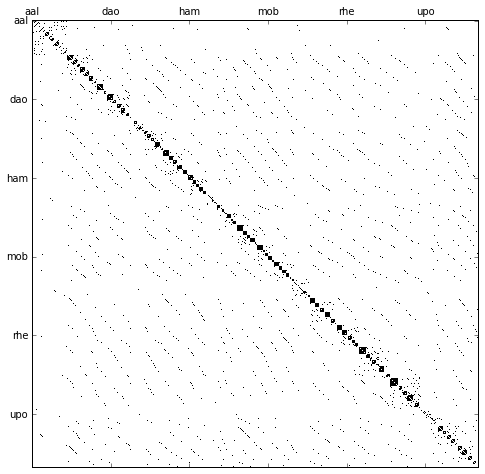

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(graph.toarray(), cmap=plt.cm.binary)

# Label axes with the words
def format_func(x, *args):
    return wordlist[max(0, min(int(x), graph.shape[0]-1))]
    
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

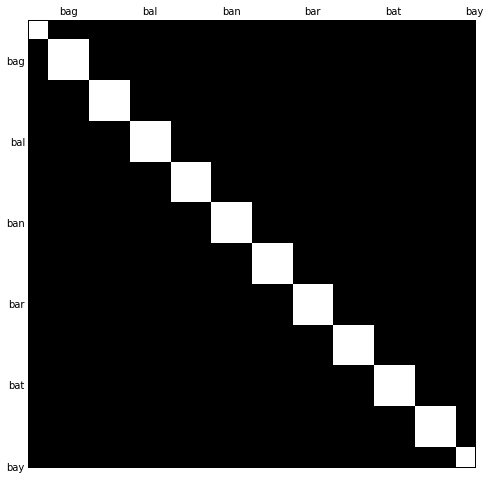

In [11]:
#Zooming on the Diagonal
ax.set_xlim(93, 104)
ax.set_ylim(104,93)
fig